# README

This delivery contains the implementation of the 3rd task of the "Automatic Signal Detector" project of the Computer Vision course.
In order to run succesfully, one must download the harcascade from 

*   https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml

Import them in their own drive and change the path in the "Synchronizing drive files section"

## Important notes:


1.   The cells that use the webcam run in a loop, one has to **stop manually the cell** and **re-run the notebook from the next cell** to run the rest of the notebook successfully.

2.   In the "Mean shift" section there is **an image** imported from the owner's drive which **will not be available**. To watch it, one must see it in the mentioned section **before the first run.**

# TASK 3 - MACHINE LEARNING AND COMPUTER VISION PROJECT

Author: Nicolás Arrieta Larraza

Date: 12/03/2021

## Initializing

### Importing libraries

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from google.colab.patches import cv2_imshow
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import io
import cv2 # OpenCV library

In [ ]:
cv2.__version__

'4.1.2'

### Synchronizing Drive files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change for custom location
face_cascade_path = "/content/drive/MyDrive/UCA/ComputerVision/task_1/haarcascade_frontalface_default.xml"

### Importing the cascade filter to OpenCV

In [ ]:
face_cascades = cv2.CascadeClassifier(face_cascade_path)

## Defining functions

Function to capture video from computer webcam trough the web browser (given)

In [ ]:
from google.colab.output import eval_js

def VideoCapture():
  js = Javascript('''
    async function create(){
      div = document.createElement('div');
      document.body.appendChild(div);

      video = document.createElement('video');
      video.setAttribute('playsinline', '');

      div.appendChild(video);
      stream = await navigator.mediaDevices.getUserMedia({video: {facingMode: "environment"}});
      video.srcObject = stream;

      await video.play();

      canvas =  document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      div_out = document.createElement('div');
      document.body.appendChild(div_out);
      img = document.createElement('img');
      div_out.appendChild(img);
    }

    async function capture(){
        return await new Promise(function(resolve, reject){
            pendingResolve = resolve;
            canvas.getContext('2d').drawImage(video, 0, 0);
            result = canvas.toDataURL('image/jpeg', 0.20);

            pendingResolve(result);
        })
    }

    function showimg(imgb64){
        img.src = "data:image/jpg;base64," + imgb64;
    }

  ''')
  display(js)

Functions to convert base64 to bytes array format and viceversa (given). These functions are necessary since the images in Javascript work with base64 format and OpenCV works with bytes array.

In [ ]:
def b64_to_bytes(byte):
  jpeg = b64decode(byte.split(',')[1])
  im = Image.open(io.BytesIO(jpeg))
  return np.array(im)

def bytes_to_b64(image):
  image = Image.fromarray(image)
  buffer = io.BytesIO()
  image.save(buffer, 'jpeg')
  buffer.seek(0)
  x = b64encode(buffer.read()).decode('utf-8')
  return x

Function to plot histogram of colors

In [ ]:
def show_hist(hist):
  bin_count = hist.shape[0]
  bin_w = 24
  img = np.zeros((256, bin_count*bin_w, 3), np.uint8)
  for i in range(bin_count):
      h = int(hist[i])
      cv2.rectangle(img, (i*bin_w+2, 255), ((i+1)*bin_w-2, 255-h), (int(180.0*i/bin_count), 255, 255), -1)
  img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
  cv2_imshow(img)

Function to compute face recognition

In [ ]:
def detect_faces(img, cascades):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = cascades.detectMultiScale(gray, 1.3, 4)
  return faces

## Capturing region of the recognized faced

First, we need to capture a frame of a face in order to compute it's histogram

In [ ]:
VideoCapture()
eval_js('create()')

while True:
  response = input("Type anything when ready!:")

  # Detecting faces
  byte = eval_js('capture()')
  im = b64_to_bytes(byte)
  im_copy = im.copy()
  faces = detect_faces(im, face_cascades)

  # Drawing a green rectangle in face's region
  if len(faces) == 1:
    face = faces[0]
    cv2.rectangle(im_copy,(face[0],face[1]),(face[0] + face[2], face[1] + face[3]),(0,255,0),2)
  else:
    continue
  # Showing capture
  eval_js('showimg("{}")'.format(bytes_to_b64(im_copy)))
  response = input("Use this bounding box? [y or n]:")
  # We offer the user the option to keep the previous frame or redo it
  if response == 'y':
    # In case of accepting we show the selected face frame
    frame = im[face[1]:face[1]+face[3], face[0]:face[0]+face[2]]
    eval_js('showimg("{}")'.format(bytes_to_b64(frame)))
    # Intialize the tracking window with this position
    tracking_window = face
    break

<IPython.core.display.Javascript object>

Type anything when ready!:a
Use this bounding box? [y or n]:y


## Building histogram from detected face

We compute the histogram of color (only HUE channel) of the face region in order to "back project" it in the entire region. Then we check fro every pixel in the image the probability of its color to be part of the histogram. Therefore, the parts of the body with similar colors will show also high probability like arms, hands, etc.

In [ ]:
# Transform the previous frame into HSV
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
# Creating an inRange mask for pixels
mask = cv2.inRange(hsv,np.array((0,64,32)), np.array((180,200,200)))
# Compute the histogram of the frame (use only the HUE channel). See `https://bit.ly/3pdVUEd`
# Take into account only pixels which are not too bright and not too dark (use the previous mask)
# Use 16 bins and speicfy the range of the hue ([0, 180])
hist = cv2.calcHist([hsv],[0], mask, [16], [0,180])
# Normalize the histogram between 0 (lowest intensity) and 255 (highest intensity) (use MinMax normalization `cv.NORM_MINMAX`) using the method `https://bit.ly/3jMGhCj`
hist = cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)
# Reashape the histogram into a 1-D array (use `.reshape(-1)`)
hist = hist.reshape(-1)
# Show the histogram
show_hist(hist)

## Applying Mean Shift

In this section we will apply Mean Shift to track our face by using the back projection of the previous computed histogram of colors in the entire image. Mean Shift will move the frame box to the points with highest probability (sections of the body with similar colors as the histogram)

In [ ]:
VideoCapture()
eval_js('create()')

# This means: Stop the mean-shift algorithm iff we effectuated 10 iterations or the computed mean does not change by more than 1pt ~ 1.3px in both directions
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

while True:
  byte = eval_js('capture()') # Take a capture
  im = b64_to_bytes(byte)

  # Convert the capture in HSV
  hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
  # Compute an inRange mask  as before with the frame
  mask = cv2.inRange(hsv,np.array((0,64,32)), np.array((180,200,200)))
  # Back project the frame histogram into the hsv image. Use only channel 0 (Hue), range of [0,180] and scale of 1
  back_pro = cv2.calcBackProject([hsv],[0], hist, [0,180], scale=1)
  # Bitwise and the back projection and the previously computed mask in order to remove very bright or very dark pixels (you can use `&` of python or cv2.bitwise_and in opencv)
  back_pro = mask & back_pro
  
  # Applying Mean shift
  _, tracking_window = cv2.meanShift(back_pro, tracking_window, term_crit)
  # plot a bounding box with coordiantes `tracking_window` in the image
  (x,y,w,h) = tracking_window
  cv2.rectangle(im, (x,y), (x+w, y+h), (255,0,0), 2)  
  eval_js('showimg("{}")'.format(bytes_to_b64(im)))

### Showing back projection of histogram

Below we can find a capture of the Mean Shift code above showing the histogram back projection instead of the image. As we it can be observed, the regions with more density of probability are the parts of the body like the face, neck and hand, and the rest of the environment is not considered.

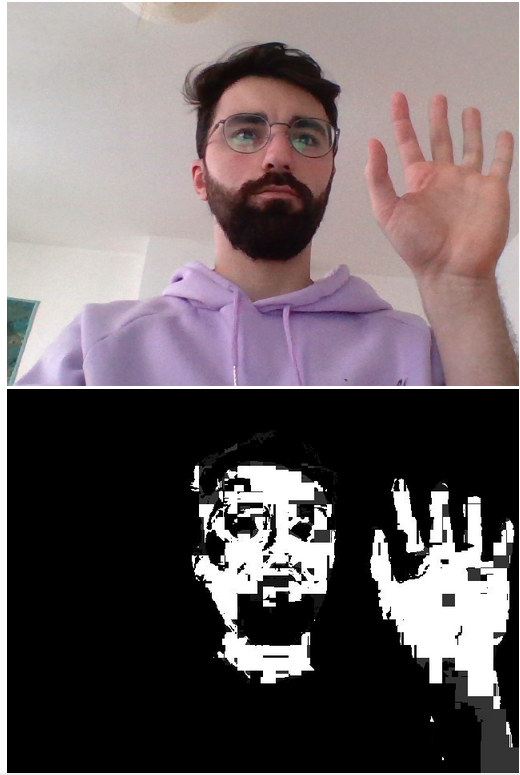

In [ ]:
try:
  img_backpro = "/content/drive/MyDrive/UCA/ComputerVision/third_task/back_pro.png"
  img = Image.open(img_backpro)
  display(img)
except:
  print("Image only available for owner, try to watch it before running the notebook for first time")

## Applying Cam Shift

We desire a bounding box that changes its size in case of different distance of the face to the camera and rotates if the face leans left and right. In order to apply this features to make an adaptative bounding box, we are going to apply an advance version of Mean Shift called Cam Shift (Continuously Adaptive Meanshift).

In [ ]:
VideoCapture()
eval_js('create()')

# These mean: Stop the mean-shift algorithm iff we effectuated 10 iterations or the computed mean does not change by more than 1pt ~ 1.3px in both directions
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

while True:
  byte = eval_js('capture()') # Take a capture
  im = b64_to_bytes(byte)

  # Convert the capture in HSV
  hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
  # Compute an inRange mask  as before with the frame
  mask = cv2.inRange(hsv,np.array((0,64,32)), np.array((180,200,200)))
  # Back project the frame histogram into the hsv image. Use only channel 0 (Hue), range of [0,180] and scale of 1
  back_pro = cv2.calcBackProject([hsv],[0], hist, [0,180], scale=1)
  # Bitwise and the back projection and the previously computed mask in order to remove very bright or very dark pixels (you can use `&` of python or cv2.bitwise_and in opencv)
  back_pro = mask & back_pro

  # Applying cam shift
  bbox, tracking_window = cv2.CamShift(back_pro, tracking_window, term_crit)
  # Finding the four vertices of a rotated rectangle to draw it
  pts = cv2.boxPoints(bbox).astype(np.int)
  cv2.polylines(im, [pts], True, (255, 0 , 0), 2)
  eval_js('showimg("{}")'.format(bytes_to_b64(im)))

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored